In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from tensorflow.keras.optimizers import Adam

In [2]:
IMAGE_WIDTH= 48
IMAGE_HEIGHT= 48
IMAGE_CHANNELS= 1
IMAGE_SIZE= (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
EPOCHS = 20
optimizer = Adam(learning_rate=0.001)
earlystop = EarlyStopping(patience=5)
path_test = '../data/images/test'

In [3]:
def get_image_path(id):
    return os.path.join(path_test, f"{id}.jpg")

In [4]:
def procesar_imagen(path):
        img = cv2.imread(path, 0)
        img_scale = np.array(img) / 255.0
        return img_scale

In [5]:
train = pd.read_csv('./train_set.csv')
test = pd.read_csv('./test_set.csv')
sample = pd.read_csv('./sample_submision.csv')

In [6]:
test['path'] = test['id_img'].apply(get_image_path)

In [7]:
ruta_imagen = train.loc[0, 'path']
ruta_imagen

'../data/images/train/angry\\0.jpg'

In [8]:
train['Imagenes'] = train['path'].apply(procesar_imagen)

In [9]:
test['Imagenes'] = test['path'].apply(procesar_imagen)

In [10]:
train

,id_img,path,label,Imagenes
0,0,../data/images/train/angry\0.jpg,angry,"[[0.2823529411764706, 0.3058823529411765, 0.31..."
1,1,../data/images/train/angry\1.jpg,angry,"[[0.596078431372549, 0.5843137254901961, 0.576..."
2,10,../data/images/train/angry\10.jpg,angry,"[[0.11372549019607843, 0.09803921568627451, 0...."
3,10002,../data/images/train/angry\10002.jpg,angry,"[[0.12549019607843137, 0.09019607843137255, 0...."
4,10016,../data/images/train/angry\10016.jpg,angry,"[[0.8705882352941177, 0.8549019607843137, 0.79..."
...,...,...,...,...
28816,9969,../data/images/train/surprise\9969.jpg,surprise,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00..."
28817,9985,../data/images/train/surprise\9985.jpg,surprise,"[[0.5098039215686274, 0.5254901960784314, 0.51..."
28818,9990,../data/images/train/surprise\9990.jpg,surprise,"[[0.9529411764705882, 0.8627450980392157, 0.81..."
28819,9992,../data/images/train/surprise\9992.jpg,surprise,"[[0.9921568627450981, 0.9882352941176471, 0.99..."


In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train['label_encoded'] = label_encoder.fit_transform(train['label'])

In [12]:
train['label_encoded'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [13]:
train = train.sample(frac=1).reset_index(drop=True)

In [14]:
train

,id_img,path,label,Imagenes,label_encoded
0,13181,../data/images/train/sad\13181.jpg,sad,"[[0.01568627450980392, 0.023529411764705882, 0...",5
1,6048,../data/images/train/happy\6048.jpg,happy,"[[0.07450980392156863, 0.07058823529411765, 0....",3
2,23546,../data/images/train/sad\23546.jpg,sad,"[[0.3411764705882353, 0.3333333333333333, 0.32...",5
3,22880,../data/images/train/angry\22880.jpg,angry,"[[0.38823529411764707, 0.27450980392156865, 0....",0
4,9625,../data/images/train/happy\9625.jpg,happy,"[[0.7568627450980392, 0.7137254901960784, 0.62...",3
...,...,...,...,...,...
28816,34263,../data/images/train/neutral\34263.jpg,neutral,"[[0.16862745098039217, 0.1607843137254902, 0.1...",4
28817,498,../data/images/train/neutral\498.jpg,neutral,"[[0.9764705882352941, 0.9725490196078431, 0.97...",4
28818,12205,../data/images/train/fear\12205.jpg,fear,"[[0.12549019607843137, 0.21176470588235294, 0....",2
28819,28740,../data/images/train/neutral\28740.jpg,neutral,"[[0.23529411764705882, 0.2980392156862745, 0.3...",4


In [15]:
X_train = np.stack(train['Imagenes'].values)
y_train = np.array(train['label_encoded'])
X_test = np.stack(test['Imagenes'].values)

In [16]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)

(28821, 48, 48)
(28821,)
(7066, 48, 48)


In [17]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [18]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)

(28821, 48, 48, 1)
(28821,)
(7066, 48, 48, 1)


In [19]:
# model = keras.Sequential([
#     keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(IMAGE_SIZE)),
#     keras.layers.MaxPooling2D(2,2),
#     keras.layers.Conv2D(32, (3,3), activation="relu"),
#     keras.layers.MaxPooling2D(2,2),
#     keras.layers.Flatten(),
#     keras.layers.Dense(64, activation="relu"),
#     keras.layers.Dense(16, activation="relu"),
#     keras.layers.Dense(7, activation="softmax")
# ])

In [20]:
# model.compile(optimizer='adam',
#               loss="sparse_categorical_crossentropy",
#               metrics=['accuracy'])

In [21]:
# history = model.fit(X_train,
#                     y_train,
#                     batch_size=BATCH_SIZE,
#                     epochs=EPOCHS,
#                     validation_split=0.2)

In [22]:
model_2 = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(IMAGE_SIZE)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(7, activation="softmax")
    
])

model_2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [23]:
history_2 = model_2.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=7,
                    callbacks = earlystop,
                    validation_split=0.2)

Epoch 1/7


721/721 [==============================] - 10s 13ms/step - loss: 1.7655 - accuracy: 0.2804 - val_loss: 1.6661 - val_accuracy: 0.3324
Epoch 2/7
721/721 [==============================] - 9s 13ms/step - loss: 1.5671 - accuracy: 0.3931 - val_loss: 1.5256 - val_accuracy: 0.4014
Epoch 3/7
721/721 [==============================] - 9s 13ms/step - loss: 1.4461 - accuracy: 0.4403 - val_loss: 1.4407 - val_accuracy: 0.4363
Epoch 4/7
721/721 [==============================] - 9s 12ms/step - loss: 1.3748 - accuracy: 0.4680 - val_loss: 1.3821 - val_accuracy: 0.4656
Epoch 5/7
721/721 [==============================] - 9s 12ms/step - loss: 1.3174 - accuracy: 0.4957 - val_loss: 1.3542 - val_accuracy: 0.4746
Epoch 6/7
721/721 [==============================] - 9s 12ms/step - loss: 1.2759 - accuracy: 0.5094 - val_loss: 1.3462 - val_accuracy: 0.4853
Epoch 7/7
721/721 [==============================] - 9s 12ms/step - loss: 1.2321 - accuracy: 0.5284 - val_loss: 1.3499 - val_accuracy: 0.4885


In [76]:
history_2 = model_2.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=3,
                    callbacks = earlystop,
                    validation_split=0.2)

Epoch 1/3
721/721 [==============================] - 9s 12ms/step - loss: 1.1915 - accuracy: 0.5463 - val_loss: 1.3199 - val_accuracy: 0.5030
Epoch 2/3
721/721 [==============================] - 9s 12ms/step - loss: 1.1557 - accuracy: 0.5619 - val_loss: 1.3241 - val_accuracy: 0.5042
Epoch 3/3
721/721 [==============================] - 9s 12ms/step - loss: 1.1197 - accuracy: 0.5765 - val_loss: 1.3291 - val_accuracy: 0.5062


In [24]:
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

In [25]:
best_epoch = val_loss.index(min(val_loss)) + 1

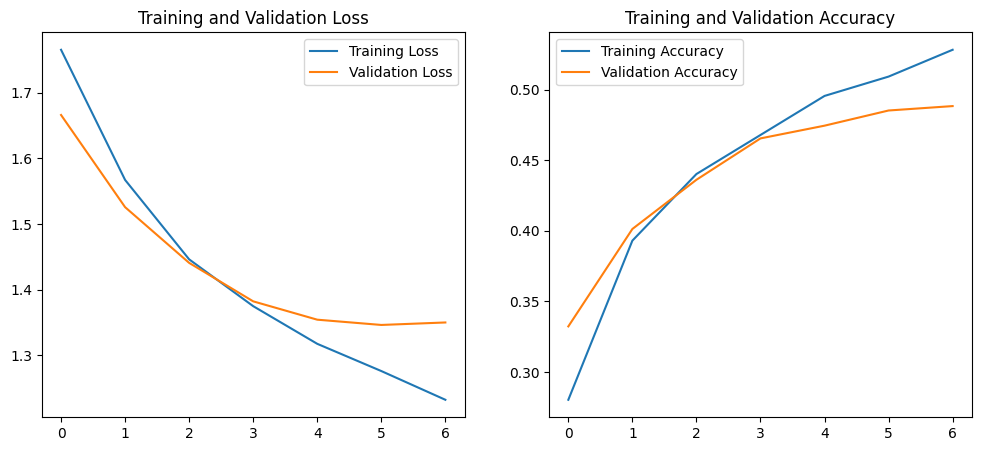

In [26]:
# Acceder a los datos del historial
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
accuracy = history_2.history['accuracy']  # Cambia 'accuracy' por la métrica que usaste
val_accuracy = history_2.history['val_accuracy']  # Ídem

# Crear gráficos para pérdida y precisión
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [77]:
y_pred_2 = model_2.predict(X_test)

221/221 [==============================] - 1s 3ms/step


In [78]:
# layers = [
#     keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SIZE),
#     keras.layers.MaxPooling2D(pool_size=(2,2)),
    
#     keras.layers.Conv2D(64, (3,3), activation='relu'),
#     keras.layers.MaxPooling2D(pool_size=(2,2)),
    
#     keras.layers.Flatten(),
    
#     keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     keras.layers.Dropout(0.5),
    
#     keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     keras.layers.Dropout(0.5),
    
#     keras.layers.Dense(7, activation='softmax')
# ]

# model_3 = keras.Sequential(layers)
# model_3.compile(optimizer=optimizer,
#                 loss='sparse_categorical_crossentropy',
#                 metrics=['accuracy'])

In [79]:
# history_3 = model_3.fit(X_train,
#                     y_train,
#                     batch_size=BATCH_SIZE,
#                     epochs=9,
#                     callbacks = earlystop,
#                     validation_split=0.2)

In [30]:
# loss_2 = history_3.history['loss']
# val_loss_2 = history_3.history['val_loss']

In [31]:
# best_epoch = val_loss_2.index(min(val_loss_2)) + 1

In [32]:
# y_pred_3 = model_3.predict(X_test)

221/221 [==============================] - 1s 2ms/step


In [39]:
y_pred_2[0]

array([0.09167407, 0.00158398, 0.1101916 , 0.36441675, 0.2183063 ,
       0.1895076 , 0.02431967], dtype=float32)

In [40]:
y_pred_3[0]

array([0.1731687 , 0.02250624, 0.1534915 , 0.17107143, 0.21804938,
       0.23121133, 0.03050139], dtype=float32)

In [44]:
pred_labels2 = np.argmax(y_pred_2, axis=1)
pred_labels2

array([3, 5, 5, ..., 6, 4, 6], dtype=int64)

In [69]:
pred_labels3 = np.argmax(y_pred_3, axis=1)
pred_labels3

array([5, 6, 4, ..., 6, 4, 6], dtype=int64)

In [54]:
y_pred_3.shape

(7066, 7)

In [70]:
submi_3 = label_encoder.inverse_transform(pred_labels3)

In [71]:
submi_2 = label_encoder.inverse_transform(pred_labels2)

In [57]:
submi_3

array(['happy', 'sad', 'sad', ..., 'surprise', 'neutral', 'surprise'],
      dtype=object)

In [72]:
submission_1 = pd.DataFrame({'id_img': test['id_img'].values, 'label': submi_2})

In [73]:
submission_2 = pd.DataFrame({'id_img': test['id_img'].values, 'label': submi_3})

In [60]:
submission_1

,id_img,label
0,10052,happy
1,10065,sad
2,10079,sad
3,10095,sad
4,10121,angry
...,...,...
7061,9806,surprise
7062,9830,surprise
7063,9853,surprise
7064,9878,neutral


In [74]:
submission_1.to_csv('submission_1.csv', index=False)

In [75]:
submission_2.to_csv('submission_2.csv', index=False)
# ESTE VALE MIERDA

In [ ]:
model_2 = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(IMAGE_SIZE)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(7, activation="softmax")
    
])

model_2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])